Imports

In [1]:
from Dataset import processData
import Dataset
import os
from Model import train, KGLinkPredictor
import torch

Process Data

In [2]:
data, ptrain_loader, pval_loader,ftrain_loader, fval_loader, ftest_loader, df = processData(256,2048,'ourkg_raw.csv')

Loading data from path: /opt/scratch/labs/wuc/Drug-Repurposing/data/ourkg_raw.csv
Processing node data...
Processing edge data...
Setting up pretraining data...
Setting up finetuning data...
Data processing complete.


Declare and Train Model

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = KGLinkPredictor(256,64,data).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
data = data.to(device)

print('Pretraining...')
train(ptrain_loader,pval_loader, model, optimizer, device, 1) # Takes about 30 mins

model.Decoder.reset_parameters()

print('Fine-tuning...')
train(ftrain_loader,fval_loader, model, optimizer, device, 50)

Pretraining...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 | Average Training Loss: 0.2953625881002571 Average Validation Loss: 0.21978061337193305
Fine-tuning...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 | Average Training Loss: 0.41936122743706955 Average Validation Loss: 0.3047602077325185
Epoch 2 | Average Training Loss: 0.27013272203897176 Average Validation Loss: 0.2677250454823176
Epoch 3 | Average Training Loss: 0.2554880960991508 Average Validation Loss: 0.2582600216070811
Epoch 4 | Average Training Loss: 0.2506125647770731 Average Validation Loss: 0.23309420545895895
Epoch 5 | Average Training Loss: 0.2403446028107091 Average Validation Loss: 0.23348972698052725
Epoch 6 | Average Training Loss: 0.23621223474803724 Average Validation Loss: 0.25079866250356037
Epoch 7 | Average Training Loss: 0.23685398227290103 Average Validation Loss: 0.23218186696370444
Epoch 8 | Average Training Loss: 0.235536285921147 Average Validation Loss: 0.23689731458822885
Epoch 9 | Average Training Loss: 0.23128430388475718 Average Validation Loss: 0.23408070703347525
Epoch 10 | Average Training Loss: 0.2270126672167527 Average Validation Loss: 0.23677703738212585
Epoch 11 | Average Training 

Save Model

In [6]:
torch.save(model.state_dict(), r'models/2L_GAT_SILU_E50.pt')

Load Model

In [7]:
model = KGLinkPredictor(256,64,data).to(device)
model.load_state_dict(torch.load(r'models/2L_GAT_SILU_E50.pt'))

<All keys matched successfully>

Evaluation

In [63]:
import numpy as np
y = np.array([])
y_hat = np.array([])

for batch in fval_loader:
    
    # Send data to GPU
    head_indices,relations,tail_indices = batch[:,0], batch[:,1], batch[:,2]
    head_indices,relations,tail_indices = head_indices.to(device),relations.to(device),tail_indices.to(device)
    
    # Forward pass through model to update node embeddings
    model(head_indices,relations,tail_indices)
    
    y = np.append(y,len(batch)*[1])
    y_hat = np.append(y_hat,torch.sigmoid(model.Decoder(head_indices,relations,tail_indices)).detach().cpu().numpy().flatten())
    y = np.append(y,len(batch)*[0])
    y_hat = np.append(y_hat,torch.sigmoid(model.Decoder(*model.Decoder.random_sample(head_indices, relations, tail_indices), loss_tag=False)).detach().cpu().numpy().flatten())

0.9028349176345972


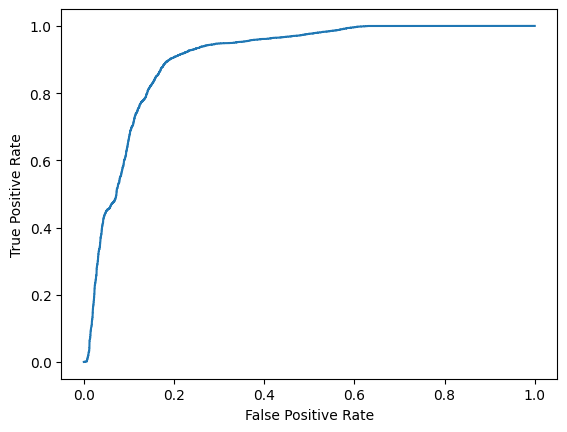

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(y, y_hat)
print(roc_auc_score(y, y_hat))

In [78]:
from sklearn.metrics import f1_score
for thresh in range(-45,50,1):
    thresh = thresh/100
    y_hat_mod = np.round(y_hat-thresh)
    print(thresh,"|",f1_score(y, y_hat_mod))

-0.45 | 0.6861164052191762
-0.44 | 0.6912340299830145
-0.43 | 0.6944650541623386
-0.42 | 0.696999031945789
-0.41 | 0.6981948381321795
-0.4 | 0.6991857772465826
-0.39 | 0.7002843034565315
-0.38 | 0.701333732953694
-0.37 | 0.7033891936574735
-0.36 | 0.7045009784735813
-0.35 | 0.7064684127103933
-0.34 | 0.7087150753388355
-0.33 | 0.7102208058274527
-0.32 | 0.7116788321167884
-0.31 | 0.7129798903107861
-0.3 | 0.7141767129558981
-0.29 | 0.7157604955264968
-0.28 | 0.7167470709855273
-0.27 | 0.7172963445474749
-0.26 | 0.717736369910283
-0.25 | 0.7184525637089346
-0.24 | 0.7190596911730814
-0.23 | 0.7196678456097186
-0.22 | 0.7204433497536946
-0.21 | 0.7209983053458635
-0.2 | 0.7219436945622831
-0.19 | 0.7228915662650602
-0.18 | 0.7237299930410578
-0.17 | 0.72513170127053
-0.16 | 0.7263133390238224
-0.15 | 0.7271597265382225
-0.14 | 0.7278382581648521
-0.13 | 0.7282346533883141
-0.12 | 0.7286314806165344
-0.11 | 0.7290855273407073
-0.1 | 0.7295970067815105
-0.09 | 0.7303370786516854
-0.08 | 0.